In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

file_path = "/Users/bingbing/Desktop/FTCCASE/Dataset for FTC Case - September 2025.xlsx"
df = pd.read_excel("/Users/bingbing/Desktop/FTCCASE/Dataset for FTC Case - September 2025.xlsx", sheet_name='Sheet1')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

Dataset Shape: (118, 11)

First 5 rows:
   Pieces Bought (Sellin QTY) Market                           Item Name  \
0                      4272.0   DK01     BOWL AS SPIDERWEB BLACK 27,5 CM   
1                         NaN   DK01     BOWL AS SPIDERWEB BLACK 27,5 CM   
2                         NaN   DK01     BOWL AS SPIDERWEB BLACK 27,5 CM   
3                      1440.0   DK01  CANDY JAR PUMPKIN SHAPE PINK SMALL   
4                         NaN   DK01  CANDY JAR PUMPKIN SHAPE PINK SMALL   

  Category               Subcategory                 Theme Commercial  \
0    Party  Table & floor decoration  Halloween Create and Decorate 2   
1    Party  Table & floor decoration  Halloween Create and Decorate 2   
2    Party  Table & floor decoration  Halloween Create and Decorate 2   
3  Kitchen        Storage/containers                  Halloween Rebel   
4  Kitchen        Storage/containers                  Halloween Rebel   

   Year Week  Sales Revenue (DKK)  Pieces Sold  Gross Profit (DK

In [5]:
# Data Cleaning and Type Conversion
df['Pieces Bought (Sellin QTY)'] = df['Pieces Bought (Sellin QTY)'].fillna(0).astype(int)
df['Week'] = (df['Year Week'] * 100 % 100).astype(int)
df = df.drop('Year Week', axis=1) 
print("\nAfter cleaning - Data Types:")
print(df.dtypes)
print("\nSample of cleaned Week column:")
print(df[['Week']].head(10))


After cleaning - Data Types:
Pieces Bought (Sellin QTY)      int64
Market                         object
Item Name                      object
Category                       object
Subcategory                    object
Theme Commercial               object
Sales Revenue (DKK)           float64
Pieces Sold                     int64
Gross Profit (DKK)            float64
# Stores w Sales                int64
Week                            int64
dtype: object

Sample of cleaned Week column:
   Week
0    38
1    39
2    40
3    37
4    38
5    39
6    40
7    36
8    37
9    38


In [80]:
pd.set_option('display.float_format', '{:.2f}'.format)
# Aggregate key metrics by Item Name
item_performance = df.groupby('Item Name').agg({
    'Sales Revenue (DKK)': 'sum',
    'Gross Profit (DKK)': 'sum', 
    'Pieces Sold': 'sum',
    'Pieces Bought (Sellin QTY)': 'sum'
}).reset_index()

# caculate margin and sell-through rate
item_performance['Margin %'] = (item_performance['Gross Profit (DKK)'] / item_performance['Sales Revenue (DKK)'] * 100).round(2)
item_performance['Sell-through %'] = (item_performance['Pieces Sold'] / item_performance['Pieces Bought (Sellin QTY)'] * 100).round(2)

# re-name colums
item_performance = item_performance.rename(columns={
    'Sales Revenue (DKK)': 'Total_Revenue',
    'Gross Profit (DKK)': 'Total_Gross_Profit',
    'Pieces Sold': 'Total_Pieces_Sold', 
    'Pieces Bought (Sellin QTY)': 'Total_Pieces_Bought'
})

print("=== ITEM PERFORMANCE SUMMARY ===")
print(f"Total items analyzed: {len(item_performance)}")
revenue_sorted = item_performance.sort_values('Total_Revenue', ascending=False)
margin_sorted = item_performance.sort_values('Margin %', ascending=False)
sellthrough_sorted = item_performance.sort_values('Sell-through %', ascending=False)

pd.set_option('display.max_columns', None)
print("\nDetailed Performance Table (sorted by Revenue):")
print(revenue_sorted[['Item Name', 'Total_Revenue', 'Margin %', 'Sell-through %']].to_string(index=False))
print("\nDetailed Performance Table (sorted by Margin):")
print(margin_sorted[['Item Name', 'Margin %','Total_Revenue','Sell-through %']].to_string(index=False))
print("\nDetailed Performance Table (sorted by Sell-through):")
print(sellthrough_sorted[['Item Name','Sell-through %','Total_Revenue', 'Margin %']].to_string(index=False))

print("\n=== KEY STATISTICS ===")
print(f"Average Margin: {item_performance['Margin %'].mean():.2f}%")
print(f"Average Sell-through: {item_performance['Sell-through %'].mean():.2f}%")
print(f"Total Revenue across all items: {item_performance['Total_Revenue'].sum():,.0f} DKK")
print(f"Total Gross Profit: {item_performance['Total_Gross_Profit'].sum():,.0f} DKK")

=== ITEM PERFORMANCE SUMMARY ===
Total items analyzed: 10

Detailed Performance Table (sorted by Revenue):
                                    Item Name  Total_Revenue  Margin %  Sell-through %
                  MUG WITH HANDLE GHOST 300ML      263768.67     83.42           46.49
                 H/W CHOCOLATE PUMPKINS 100 G      122299.16     57.31           42.33
            H/W LOLLIPOP ZOMBIE FINGERS 4X20G      117621.32     61.92           73.62
                            PUMPKIN LED BLACK      100696.31     64.23           32.94
               STICKER PUFFED HALLOWEEN 4 MIX       91589.25     77.76           38.22
           CANDY JAR PUMPKIN SHAPE PINK SMALL       89883.92     71.37           48.14
              BOWL AS SPIDERWEB BLACK 27,5 CM       71539.17     73.44           55.47
                           TOTE BAG SPIDERWEB       65361.59     75.49           34.63
  LIGHT BOX A5 WITH COLOR CHANGING LIGHT PINK       30739.01     71.30           16.63
JEWELS STICKER FOR FACE

In [81]:
pd.set_option('display.float_format', '{:.2f}'.format)
# Based on actual data distribution to set quadrant thresholds
print("=== Quadrant Threshold Setting Based on Actual Data ===")
# Revenue threshold analysis - clear segmentation
# Top 3: 263K, 122K, 117K | Bottom 7: below 108K
revenue_threshold = 100000  # 100K DKK as high revenue threshold
# Margin threshold analysis - overall margins are high
# Median around 72-75%, below 70% can be considered low margin
margin_threshold = 70.0  # 70% as high margin threshold

print(f"Revenue threshold: {revenue_threshold:,.0f} DKK")
print(f"Margin threshold: {margin_threshold}%")
print("Sell-through: Continuous color scale (lighter = higher sell-through)")

# Apply quadrant classification
def classify_quadrant(revenue, margin):
    if revenue >= revenue_threshold and margin >= margin_threshold:
        return "Top Items"
    elif revenue >= revenue_threshold and margin < margin_threshold:
        return "Cash Cow" 
    elif revenue < revenue_threshold and margin >= margin_threshold:
        return "Hidden Gems"
    else:
        return "Bottom Items"
        
# Add quadrant classification
item_performance['Quadrant'] = item_performance.apply(
    lambda x: classify_quadrant(x['Total_Revenue'], x['Margin %']), axis=1
)

# Display classification results
print("\n=== Product Quadrant Classification Results ===")
quadrant_summary = item_performance[['Item Name', 'Total_Revenue', 'Margin %', 'Sell-through %', 'Quadrant']].sort_values('Total_Revenue', ascending=False)
print(quadrant_summary.to_string(index=False))

print(f"\n=== Quadrant Distribution Statistics ===")
print(quadrant_summary['Quadrant'].value_counts())


=== Quadrant Threshold Setting Based on Actual Data ===
Revenue threshold: 100,000 DKK
Margin threshold: 70.0%
Sell-through: Continuous color scale (lighter = higher sell-through)

=== Product Quadrant Classification Results ===
                                    Item Name  Total_Revenue  Margin %  Sell-through %    Quadrant
                  MUG WITH HANDLE GHOST 300ML      263768.67     83.42           46.49   Top Items
                 H/W CHOCOLATE PUMPKINS 100 G      122299.16     57.31           42.33    Cash Cow
            H/W LOLLIPOP ZOMBIE FINGERS 4X20G      117621.32     61.92           73.62    Cash Cow
                            PUMPKIN LED BLACK      100696.31     64.23           32.94    Cash Cow
               STICKER PUFFED HALLOWEEN 4 MIX       91589.25     77.76           38.22 Hidden Gems
           CANDY JAR PUMPKIN SHAPE PINK SMALL       89883.92     71.37           48.14 Hidden Gems
              BOWL AS SPIDERWEB BLACK 27,5 CM       71539.17     73.44        

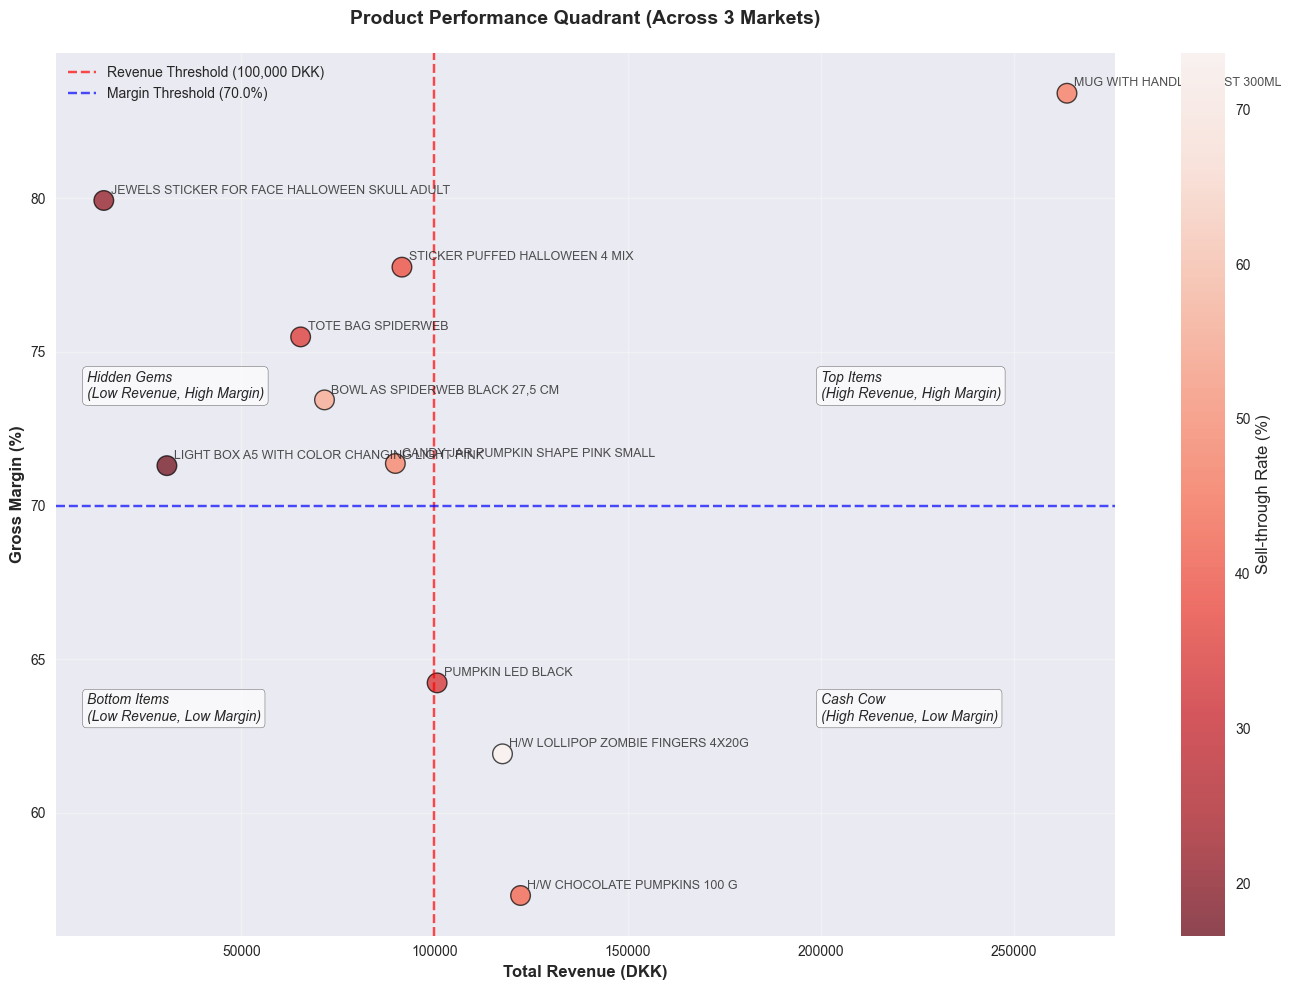

In [82]:
plt.figure(figsize=(14, 10))
# Create scatter plot with sell-through as color
scatter = plt.scatter(
    item_performance['Total_Revenue'], 
    item_performance['Margin %'],
    c=item_performance['Sell-through %'], 
    cmap='Reds_r',  # lighter colors = higher sell-through
    s=200,           # point size
    alpha=0.7,
    edgecolors='black',
    linewidth=1
)
# Add quadrant lines
plt.axvline(x=revenue_threshold, color='red', linestyle='--', alpha=0.7, label=f'Revenue Threshold ({revenue_threshold:,.0f} DKK)')
plt.axhline(y=margin_threshold, color='blue', linestyle='--', alpha=0.7, label=f'Margin Threshold ({margin_threshold}%)')
# Add labels and annotations
for i, row in item_performance.iterrows():
    plt.annotate(row['Item Name'],
                (row['Total_Revenue'], row['Margin %']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)
# Customize plot
plt.xlabel('Total Revenue (DKK)', fontsize=12, fontweight='bold')
plt.ylabel('Gross Margin (%)', fontsize=12, fontweight='bold')
plt.title('Product Performance Quadrant (Across 3 Markets)\n', 
          fontsize=14, fontweight='bold')
# Add colorbar for sell-through
cbar = plt.colorbar(scatter)
cbar.set_label('Sell-through Rate (%)', fontsize=12)
# Add quadrant labels
plt.text(revenue_threshold*2, margin_threshold*1.05, 'Top Items\n(High Revenue, High Margin)', 
         fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.text(revenue_threshold*2, margin_threshold*0.9, 'Cash Cow\n(High Revenue, Low Margin)', 
         fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.text(revenue_threshold*0.1, margin_threshold*1.05, 'Hidden Gems\n(Low Revenue, High Margin)', 
         fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.text(revenue_threshold*0.1, margin_threshold*0.9, 'Bottom Items\n(Low Revenue, Low Margin)', 
         fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [83]:
# Aggregate key metrics by Theme Commercial
theme_performance = df.groupby('Theme Commercial').agg({
    'Sales Revenue (DKK)': 'sum',
    'Gross Profit (DKK)': 'sum', 
    'Pieces Sold': 'sum',
    'Pieces Bought (Sellin QTY)': 'sum',
    'Item Name': 'nunique'  # Count unique items per theme
}).reset_index()

# Calculate margin and sell-through rate
theme_performance['Margin %'] = (theme_performance['Gross Profit (DKK)'] / theme_performance['Sales Revenue (DKK)'] * 100).round(2)
theme_performance['Sell-through %'] = (theme_performance['Pieces Sold'] / theme_performance['Pieces Bought (Sellin QTY)'] * 100).round(2)

# Rename columns for clarity
theme_performance = theme_performance.rename(columns={
    'Sales Revenue (DKK)': 'Total_Revenue',
    'Gross Profit (DKK)': 'Total_Gross_Profit',
    'Pieces Sold': 'Total_Pieces_Sold', 
    'Pieces Bought (Sellin QTY)': 'Total_Pieces_Bought',
    'Item Name': 'Number_of_Items'
})

print("=== THEME PERFORMANCE SUMMARY ===")
print(f"Total themes analyzed: {len(theme_performance)}")

# Sort by different metrics
revenue_sorted = theme_performance.sort_values('Total_Revenue', ascending=False)
margin_sorted = theme_performance.sort_values('Margin %', ascending=False)
sellthrough_sorted = theme_performance.sort_values('Sell-through %', ascending=False)

print("\nDetailed Theme Performance (sorted by Revenue):")
print(revenue_sorted[['Theme Commercial', 'Number_of_Items', 'Total_Revenue', 'Margin %', 'Sell-through %']].to_string(index=False))
print("\nDetailed Theme Performance (sorted by Margin):")
print(margin_sorted[['Theme Commercial','Number_of_Items','Margin %', 'Total_Revenue','Sell-through %']].to_string(index=False))
print("\nDetailed Theme Performance (sorted by Sell-through):")
print(sellthrough_sorted[['Theme Commercial','Number_of_Items','Sell-through %','Total_Revenue', 'Margin %']].to_string(index=False))


print("\n=== KEY THEME STATISTICS ===")
print(f"Average Theme Margin: {theme_performance['Margin %'].mean():.2f}%")
print(f"Average Theme Sell-through: {theme_performance['Sell-through %'].mean():.2f}%")
print(f"Total Revenue across all themes: {theme_performance['Total_Revenue'].sum():,.0f} DKK")

=== THEME PERFORMANCE SUMMARY ===
Total themes analyzed: 6

Detailed Theme Performance (sorted by Revenue):
               Theme Commercial  Number_of_Items  Total_Revenue  Margin %  Sell-through %
Halloween Create and Decorate 2                4      527593.40     77.42           44.86
       Halloween Food Chocolate                1      122299.16     57.31           42.33
                Halloween Rebel                2      120622.93     71.35           38.10
                 Halloween Food                1      117621.32     61.92           73.62
  Halloween Create and Decorate                1       65361.59     75.49           34.63
             Halloween Dress up                1       14403.00     79.93           20.95

Detailed Theme Performance (sorted by Margin):
               Theme Commercial  Number_of_Items  Margin %  Total_Revenue  Sell-through %
             Halloween Dress up                1     79.93       14403.00           20.95
Halloween Create and Decorate 2   

In [84]:
pd.set_option('display.float_format', '{:.2f}'.format)
# Set theme quadrant thresholds based on data distribution
print("\n=== Theme Quadrant Threshold Setting ===")
theme_revenue_threshold = theme_performance['Total_Revenue'].median()  # Median revenue as threshold
theme_margin_threshold = theme_performance['Margin %'].median()       # Median margin as threshold

print(f"Theme Revenue threshold: {theme_revenue_threshold:,.0f} DKK")
print(f"Theme Margin threshold: {theme_margin_threshold}%")

# Apply theme quadrant classification
def classify_theme_quadrant(revenue, margin):
    if revenue >= theme_revenue_threshold and margin >= theme_margin_threshold:
        return "Top Themes"
    elif revenue >= theme_revenue_threshold and margin < theme_margin_threshold:
        return "Cash Cow Themes" 
    elif revenue < theme_revenue_threshold and margin >= theme_margin_threshold:
        return "Hidden Gems Themes"
    else:
        return "Bottom Themes"

theme_performance['Theme_Quadrant'] = theme_performance.apply(
    lambda x: classify_theme_quadrant(x['Total_Revenue'], x['Margin %']), axis=1
)

print("\n=== Theme Quadrant Classification ===")
theme_quadrant_summary = theme_performance[['Theme Commercial', 'Total_Revenue', 'Margin %', 'Sell-through %', 'Number_of_Items', 'Theme_Quadrant']].sort_values('Total_Revenue', ascending=False)
print(theme_quadrant_summary.to_string(index=False))

print(f"\n=== Theme Quadrant Distribution ===")
print(theme_quadrant_summary['Theme_Quadrant'].value_counts())


=== Theme Quadrant Threshold Setting ===
Theme Revenue threshold: 119,122 DKK
Theme Margin threshold: 73.41999999999999%

=== Theme Quadrant Classification ===
               Theme Commercial  Total_Revenue  Margin %  Sell-through %  Number_of_Items     Theme_Quadrant
Halloween Create and Decorate 2      527593.40     77.42           44.86                4         Top Themes
       Halloween Food Chocolate      122299.16     57.31           42.33                1    Cash Cow Themes
                Halloween Rebel      120622.93     71.35           38.10                2    Cash Cow Themes
                 Halloween Food      117621.32     61.92           73.62                1      Bottom Themes
  Halloween Create and Decorate       65361.59     75.49           34.63                1 Hidden Gems Themes
             Halloween Dress up       14403.00     79.93           20.95                1 Hidden Gems Themes

=== Theme Quadrant Distribution ===
Theme_Quadrant
Cash Cow Themes       2


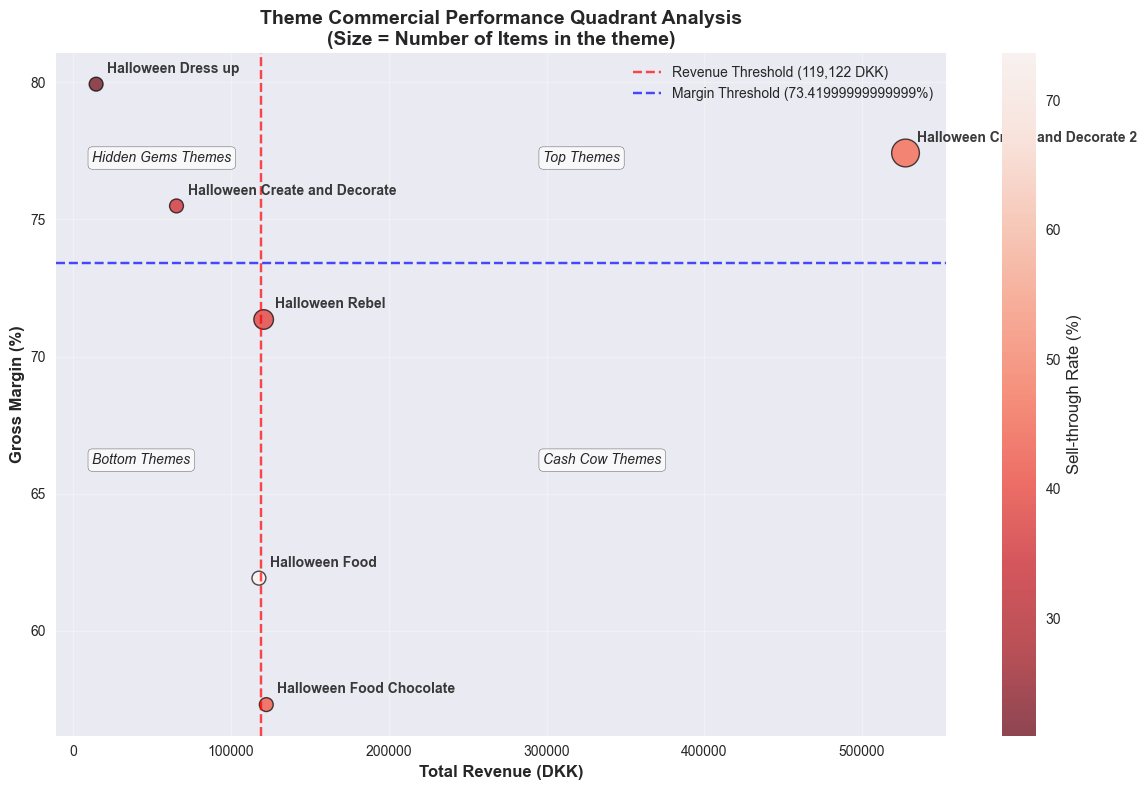

In [85]:
# Theme Performance Quadrant Chart
plt.figure(figsize=(12, 8))

# Create scatter plot for themes
scatter = plt.scatter(
    theme_performance['Total_Revenue'], 
    theme_performance['Margin %'],
    c=theme_performance['Sell-through %'], 
    cmap='Reds_r',
    s=theme_performance['Number_of_Items'] * 100,  # Size by number of items in theme
    alpha=0.7,
    edgecolors='black',
    linewidth=1
)

# Add quadrant lines
plt.axvline(x=theme_revenue_threshold, color='red', linestyle='--', alpha=0.7, 
            label=f'Revenue Threshold ({theme_revenue_threshold:,.0f} DKK)')
plt.axhline(y=theme_margin_threshold, color='blue', linestyle='--', alpha=0.7, 
            label=f'Margin Threshold ({theme_margin_threshold}%)')

# Add theme labels
for i, row in theme_performance.iterrows():
    plt.annotate(row['Theme Commercial'], 
                (row['Total_Revenue'], row['Margin %']),
                xytext=(8, 8), textcoords='offset points',
                fontsize=10, fontweight='bold', alpha=0.9)

# Customize plot
plt.xlabel('Total Revenue (DKK)', fontsize=12, fontweight='bold')
plt.ylabel('Gross Margin (%)', fontsize=12, fontweight='bold')
plt.title('Theme Commercial Performance Quadrant Analysis\n(Size = Number of Items in the theme)', 
          fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sell-through Rate (%)', fontsize=12)

# Add quadrant labels
plt.text(theme_revenue_threshold*2.5, theme_margin_threshold*1.05, 'Top Themes', 
         fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.text(theme_revenue_threshold*2.5, theme_margin_threshold*0.9, 'Cash Cow Themes', 
         fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.text(theme_revenue_threshold*0.1, theme_margin_threshold*1.05, 'Hidden Gems Themes', 
         fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.text(theme_revenue_threshold*0.1, theme_margin_threshold*0.9, 'Bottom Themes', 
         fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [86]:
!pip install scikit-learn

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Define growth factors by category based on Halloween demand patterns
CATEGORY_GROWTH_FACTORS = {
    'Food': {41: 1.3, 42: 1.7, 43: 2.0},        # High elasticity - last-minute purchases
    'Party': {41: 1.2, 42: 1.6, 43: 1.9},       # Decoration items - steady growth
    'Kitchen': {41: 1.2, 42: 1.5, 43: 1.8},     # Kitchen items - moderate growth
    'Personal care': {41: 1.1, 42: 1.4, 43: 1.6}, # Costume/makeup - earlier purchases
    'Gadget': {41: 1.2, 42: 1.5, 43: 1.8},      # Gadgets - similar to decorations
    'Hobby': {41: 1.2, 42: 1.6, 43: 1.9},       # Hobby items - steady growth
    'Textile': {41: 1.1, 42: 1.4, 43: 1.6}      # Textiles - relatively stable
}

# Risk thresholds
RISK_THRESHOLDS = {
    'stockout_risk': 90,    # Sell-through > 90% → Risk of selling out too fast
    'overstock_risk': 60,   # Sell-through < 60% → Risk of not selling out
    'healthy_range': (60, 90)
}

def prepare_training_data(item_market_data):
    """
    Prepare data for linear regression, excluding pre-sale periods
    """
    # Filter out pre-sale periods (Stores w Sales <= 4)
    training_data = item_market_data[item_market_data['# Stores w Sales'] > 4].copy()
    
    if len(training_data) < 2:  # Need at least 2 data points for regression
        return None, None
    
    # Use weeks as features for regression
    X = training_data['Week'].values.reshape(-1, 1)
    y = training_data['Pieces Sold'].values
    
    return X, y

def predict_future_sales(item_market_data, category):
    """
    Predict sales for weeks 41, 42, 43 using linear regression with growth factors
    """
    X, y = prepare_training_data(item_market_data)
    
    if X is None:
        return None
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict base sales for future weeks (without growth factors)
    future_weeks = np.array([41, 42, 43]).reshape(-1, 1)
    base_predictions = model.predict(future_weeks)
    
    # Apply category-specific growth factors
    growth_factors = CATEGORY_GROWTH_FACTORS.get(category, CATEGORY_GROWTH_FACTORS['Party'])
    adjusted_predictions = {}
    
    for i, week in enumerate([41, 42, 43]):
        base_sales = max(0, base_predictions[i])  # Ensure non-negative predictions
        growth_factor = growth_factors[week]
        adjusted_predictions[week] = base_sales * growth_factor
    
    return adjusted_predictions

def calculate_sellout_risk():
    """
    Main function to calculate sell-out risk for each item in each market
    """
    results = []
    
    # Group by both Item Name and Market
    for (item_name, market), group in df.groupby(['Item Name', 'Market']):
        category = group['Category'].iloc[0]
        subcategory = group['Subcategory'].iloc[0]
        theme = group['Theme Commercial'].iloc[0]
        
        # Calculate current totals (including all data, even pre-sale)
        total_bought = group['Pieces Bought (Sellin QTY)'].max()
        total_sold_to_date = group['Pieces Sold'].sum()
        
        # Skip if no purchase data
        if total_bought == 0:
            continue
        
        # Predict future sales
        future_predictions = predict_future_sales(group, category)
        
        if future_predictions is None:
            # Not enough data for prediction
            results.append({
                'Item Name': item_name,
                'Market': market,
                'Category': category,
                'Subcategory': subcategory,
                'Theme Commercial': theme,
                'Total_Bought': total_bought,
                'Total_Sold_To_Date': total_sold_to_date,
                'Current_Sell_Through': (total_sold_to_date / total_bought * 100),
                'Predicted_Week41_Sales': None,
                'Predicted_Week42_Sales': None,
                'Predicted_Week43_Sales': None,
                'Predicted_Final_Sell_Through': None,
                'Risk_Category': 'Insufficient Data'
            })
            continue
        
        # Calculate predicted final sell-through
        total_predicted_sales = sum(future_predictions.values())
        total_final_sold = total_sold_to_date + total_predicted_sales
        predicted_final_sell_through = (total_final_sold / total_bought * 100)
        
        # Determine risk category
        if predicted_final_sell_through > RISK_THRESHOLDS['stockout_risk']:
            risk_category = 'Stockout Risk'
        elif predicted_final_sell_through < RISK_THRESHOLDS['overstock_risk']:
            risk_category = 'Overstock Risk'
        else:
            risk_category = 'Healthy'
        
        results.append({
            'Item Name': item_name,
            'Market': market,
            'Category': category,
            'Subcategory': subcategory,
            'Theme Commercial': theme,
            'Total_Bought': total_bought,
            'Total_Sold_To_Date': total_sold_to_date,
            'Current_Sell_Through': (total_sold_to_date / total_bought * 100),
            'Predicted_Week41_Sales': future_predictions[41],
            'Predicted_Week42_Sales': future_predictions[42],
            'Predicted_Week43_Sales': future_predictions[43],
            'Predicted_Final_Sell_Through': predicted_final_sell_through,
            'Risk_Category': risk_category
        })
    
    return pd.DataFrame(results)

# Execute the analysis
print("=== HALLOWEEN SELL-OUT RISK ANALYSIS ===")

risk_analysis_df = calculate_sellout_risk()

# Display results
print(f"Total item-market combinations analyzed: {len(risk_analysis_df)}")

# Summary statistics
print("\n=== RISK CATEGORY DISTRIBUTION ===")
risk_summary = risk_analysis_df['Risk_Category'].value_counts()
print(risk_summary)

# Display high-risk items
print("\n🚨 STOCKOUT RISK ITEMS (Sell-through > 90% predicted):")
stockout_risk = risk_analysis_df[risk_analysis_df['Risk_Category'] == 'Stockout Risk']
if not stockout_risk.empty:
    print(stockout_risk[['Item Name', 'Market','Predicted_Final_Sell_Through', 'Current_Sell_Through']].sort_values('Predicted_Final_Sell_Through', ascending=False).to_string(index=False))
else:
    print("No items at high risk of stockout")

print("\n📦 OVERSTOCK RISK ITEMS (Sell-through < 60% predicted):")
overstock_risk = risk_analysis_df[risk_analysis_df['Risk_Category'] == 'Overstock Risk']
if not overstock_risk.empty:
    print(overstock_risk[['Item Name', 'Market','Predicted_Final_Sell_Through', 'Current_Sell_Through']].sort_values('Predicted_Final_Sell_Through').to_string(index=False))
else:
    print("No items at high risk of overstock")

# Detailed results for review
print("\n=== DETAILED PREDICTION RESULTS ===")
pd.set_option('display.max_rows', None)
print(risk_analysis_df[['Item Name', 'Market','Risk_Category', 'Current_Sell_Through', 'Predicted_Final_Sell_Through']].sort_values(['Risk_Category', 'Predicted_Final_Sell_Through'], ascending=[True, False]).to_string(index=False))

=== HALLOWEEN SELL-OUT RISK ANALYSIS ===
Total item-market combinations analyzed: 30

=== RISK CATEGORY DISTRIBUTION ===
Risk_Category
Stockout Risk        19
Healthy               6
Overstock Risk        4
Insufficient Data     1
Name: count, dtype: int64

🚨 STOCKOUT RISK ITEMS (Sell-through > 90% predicted):
                         Item Name Market  Predicted_Final_Sell_Through  Current_Sell_Through
    STICKER PUFFED HALLOWEEN 4 MIX   GB01                        453.42                108.47
   BOWL AS SPIDERWEB BLACK 27,5 CM   GB01                        223.06                 64.90
   BOWL AS SPIDERWEB BLACK 27,5 CM   ES01                        214.75                 65.13
 H/W LOLLIPOP ZOMBIE FINGERS 4X20G   ES01                        202.53                 58.41
       MUG WITH HANDLE GHOST 300ML   ES01                        175.99                 55.14
 H/W LOLLIPOP ZOMBIE FINGERS 4X20G   DK01                        170.78                 86.21
       MUG WITH HANDLE GHOST 3

In [87]:
# for H/W CHOCOLATE PUMPKINS 100 G   ES01  Insufficient Data , we will use the DK01's data. 
filled_risk_df = risk_analysis_df.copy()
manual_mapping = {
    'H/W CHOCOLATE PUMPKINS 100 G': 'DK01' 
}

for idx, row in filled_risk_df[filled_risk_df['Risk_Category'] == 'Insufficient Data'].iterrows():
    item_name = row['Item Name']
    
    if item_name in manual_mapping:
        reference_market = manual_mapping[item_name]
        
        # Find the reference data
        reference_data = filled_risk_df[
            (filled_risk_df['Item Name'] == item_name) & 
            (filled_risk_df['Market'] == reference_market)
        ]
        
        if not reference_data.empty:
            ref_row = reference_data.iloc[0]
            filled_risk_df.at[idx, 'Predicted_Final_Sell_Through'] = ref_row['Predicted_Final_Sell_Through']
            filled_risk_df.at[idx, 'Risk_Category'] = ref_row['Risk_Category']
            filled_risk_df.at[idx, 'Predicted_Week41_Sales'] = ref_row['Predicted_Week41_Sales']
            filled_risk_df.at[idx, 'Predicted_Week42_Sales'] = ref_row['Predicted_Week42_Sales']
            filled_risk_df.at[idx, 'Predicted_Week43_Sales'] = ref_row['Predicted_Week43_Sales']
            
            print(f"Manually updated {item_name} in {row['Market']}: Using data from {reference_market}")

print("\n=== MANUALLY UPDATED RESULTS ===")
print("=== FINAL SELL-OUT RISK ANALYSIS (CLEANED) ===")
valid_predictions = filled_risk_df[filled_risk_df['Risk_Category'] != 'Insufficient Data']

print(f"Items with valid predictions: {len(valid_predictions)}")
print("\n🚨 SELLING OUT TOO FAST:")
stockout_clean = valid_predictions[valid_predictions['Risk_Category'] == 'Stockout Risk']
print(stockout_clean[['Item Name', 'Market','Predicted_Final_Sell_Through','Current_Sell_Through']].to_string(index=False))

print("\n📦 NOT SELLING:")
overstock_clean = valid_predictions[valid_predictions['Risk_Category'] == 'Overstock Risk']
print(overstock_clean[['Item Name', 'Market', 'Predicted_Final_Sell_Through','Current_Sell_Through']].to_string(index=False))

print("\n✅ HEALTHY ITEMS:")
healthy_clean = valid_predictions[valid_predictions['Risk_Category'] == 'Healthy']
print(healthy_clean[['Item Name', 'Market', 'Predicted_Final_Sell_Through']].to_string(index=False))

Manually updated H/W CHOCOLATE PUMPKINS 100 G in ES01: Using data from DK01

=== MANUALLY UPDATED RESULTS ===
=== FINAL SELL-OUT RISK ANALYSIS (CLEANED) ===
Items with valid predictions: 30

🚨 SELLING OUT TOO FAST:
                         Item Name Market  Predicted_Final_Sell_Through  Current_Sell_Through
   BOWL AS SPIDERWEB BLACK 27,5 CM   DK01                         93.14                 22.59
   BOWL AS SPIDERWEB BLACK 27,5 CM   ES01                        214.75                 65.13
   BOWL AS SPIDERWEB BLACK 27,5 CM   GB01                        223.06                 64.90
CANDY JAR PUMPKIN SHAPE PINK SMALL   ES01                        152.01                 57.08
CANDY JAR PUMPKIN SHAPE PINK SMALL   GB01                        113.22                 56.58
      H/W CHOCOLATE PUMPKINS 100 G   DK01                        127.72                 40.27
      H/W CHOCOLATE PUMPKINS 100 G   ES01                        127.72                 25.48
      H/W CHOCOLATE PUMPKINS 100 

In [88]:
# Define constants at the top level
TARGET_SELL_THROUGH = 85

def calculate_replenishment(risk_analysis_df):
    """
    Calculate replenishment quantities for items at risk of selling out too fast
    """
    replenishment_results = []
    
    for _, item in risk_analysis_df.iterrows():
        if (item['Risk_Category'] == 'Stockout Risk' and 
            item['Current_Sell_Through'] > 50 and
            item['Predicted_Final_Sell_Through'] is not None):
            
            # Calculate required total bought to achieve 85% sell-through
            total_sold_final = item['Total_Sold_To_Date'] + item['Predicted_Week41_Sales'] + item['Predicted_Week42_Sales'] + item['Predicted_Week43_Sales']
            target_total_bought = total_sold_final / (TARGET_SELL_THROUGH / 100)
            
            # Calculate replenishment quantity
            current_total_bought = item['Total_Bought']
            replenishment_qty = max(0, target_total_bought - current_total_bought)
            
            # Round to nearest whole number (can't buy fractional items)
            replenishment_qty = round(replenishment_qty)
            
            # Calculate expected final sell-through after replenishment
            expected_final_sell_through_after_replenishment = (total_sold_final / (current_total_bought + replenishment_qty)) * 100
            
            replenishment_results.append({
                'Item Name': item['Item Name'],
                'Market': item['Market'],
                'Category': item['Category'],
                'Current_Sell_Through': item['Current_Sell_Through'],
                'Predicted_Final_Sell_Through': item['Predicted_Final_Sell_Through'],
                'Current_Total_Bought': current_total_bought,
                'Required_Replenishment': replenishment_qty,
                'New_Total_After_Replenishment': current_total_bought + replenishment_qty,
                'Expected_Final_Sell_Through_After_Replenishment': expected_final_sell_through_after_replenishment
            })
    
    return pd.DataFrame(replenishment_results)

# Execute replenishment calculation
print("=== REPLENISHMENT RECOMMENDATIONS ===")
print("For items with Stockout Risk and Current Sell-through > 50%")
print(f"Target: {TARGET_SELL_THROUGH}% sell-through by Week 43\n")

replenishment_df = calculate_replenishment(risk_analysis_df)

if not replenishment_df.empty:
    display_cols = ['Item Name', 'Market','Current_Sell_Through','Current_Total_Bought', 'Required_Replenishment',]
    print(replenishment_df[display_cols].sort_values('Required_Replenishment', ascending=False).to_string(index=False))
    

=== REPLENISHMENT RECOMMENDATIONS ===
For items with Stockout Risk and Current Sell-through > 50%
Target: 85% sell-through by Week 43

                         Item Name Market  Current_Sell_Through  Current_Total_Bought  Required_Replenishment
    STICKER PUFFED HALLOWEEN 4 MIX   GB01                108.47                  3780                   16384
   BOWL AS SPIDERWEB BLACK 27,5 CM   GB01                 64.90                  8016                   13020
   BOWL AS SPIDERWEB BLACK 27,5 CM   ES01                 65.13                  6720                   10258
 H/W LOLLIPOP ZOMBIE FINGERS 4X20G   ES01                 58.41                  5160                    7135
       MUG WITH HANDLE GHOST 300ML   ES01                 55.14                  5840                    6252
 H/W LOLLIPOP ZOMBIE FINGERS 4X20G   DK01                 86.21                  2640                    2664
 H/W LOLLIPOP ZOMBIE FINGERS 4X20G   GB01                 87.43                  3277          

In [89]:
# Define price elasticity by category
# Negative values indicate demand decreases when price increases
PRICE_ELASTICITY_BY_CATEGORY = {
    'Food': -1.2,           # More elastic - consumers are price sensitive for food
    'Party': -0.8,          # Less elastic - decorations are more necessity-driven
    'Kitchen': -0.9,        # Moderate elasticity for kitchen items
    'Personal care': -1.0,  # Moderate elasticity for costumes/makeup
    'Gadget': -0.7,         # Less elastic - novelty items have less substitutes
    'Hobby': -0.8,          # Less elastic - hobby items have loyal customers
    'Textile': -1.1         # More elastic - bags have more alternatives
}

def calculate_price_increase_recommendations(risk_analysis_df):
    """
    Calculate price increase recommendations for items with extreme stockout risk
    """
    TARGET_SELL_THROUGH = 85
    price_increase_results = []
    
    for _, item in risk_analysis_df.iterrows():
        if (item['Risk_Category'] == 'Stockout Risk' and 
            item['Predicted_Final_Sell_Through'] is not None and
            item['Predicted_Final_Sell_Through'] > 130):
            
            category = item['Category']
            elasticity = PRICE_ELASTICITY_BY_CATEGORY.get(category, -1.0)
            
            # Calculate current predicted final sales
            current_predicted_final_sales = item['Total_Sold_To_Date'] + item['Predicted_Week41_Sales'] + item['Predicted_Week42_Sales'] + item['Predicted_Week43_Sales']
            
            # Calculate required sales reduction to achieve 85% sell-through
            current_total_bought = item['Total_Bought']
            target_final_sales = current_total_bought * (TARGET_SELL_THROUGH / 100)
            
            # Calculate required sales reduction percentage
            sales_reduction_needed = (current_predicted_final_sales - target_final_sales) / current_predicted_final_sales
            sales_reduction_percentage = sales_reduction_needed * 100
            
            # Calculate required price increase using elasticity formula
            # Elasticity = (% Change in Quantity) / (% Change in Price)
            # Therefore: % Change in Price = (% Change in Quantity) / Elasticity
            required_price_increase_percentage = (sales_reduction_needed / abs(elasticity)) * 100
            
            price_increase_results.append({
                'Item Name': item['Item Name'],
                'Market': item['Market'],
                'Category': category,
                'Price_Elasticity': elasticity,
                'Current_Predicted_Final_Sell_Through': item['Predicted_Final_Sell_Through'],
                'Current_Total_Bought': current_total_bought,
                'Current_Predicted_Final_Sales': current_predicted_final_sales,
                'Target_Final_Sales': target_final_sales,
                'Sales_Reduction_Needed_%': sales_reduction_percentage,
                'Required_Price_Increase_%': required_price_increase_percentage,
                'New_Expected_Sell_Through_After_Price_Increase': TARGET_SELL_THROUGH
            })
    
    return pd.DataFrame(price_increase_results)

# Execute price increase analysis
print("=== PRICE INCREASE RECOMMENDATIONS ===")
print("For items with extreme Stockout Risk (Predicted Final Sell-through > 130%)")
print(f"Target: Reduce demand to achieve {TARGET_SELL_THROUGH}% sell-through\n")

price_increase_df = calculate_price_increase_recommendations(risk_analysis_df)

if not price_increase_df.empty:
    display_cols = ['Item Name', 'Market','Current_Predicted_Final_Sell_Through', 'Required_Price_Increase_%',]
    
    print(price_increase_df[display_cols].sort_values('Required_Price_Increase_%', ascending=False).to_string(index=False))
# Example calculation explanation
if not price_increase_df.empty:
    print("\n🧮 EXAMPLE CALCULATION:")
    example = price_increase_df.iloc[0]
    print(f"Item: {example['Item Name']} ({example['Category']})")
    print(f"Elasticity: {example['Price_Elasticity']}")
    print(f"Current predicted sell-through: {example['Current_Predicted_Final_Sell_Through']:.1f}%")
    print(f"Sales reduction needed: {example['Sales_Reduction_Needed_%']:.1f}%")
    print(f"Required price increase: {example['Required_Price_Increase_%']:.1f}%")
    print(f"Formula: Price Increase % = (Sales Reduction % / Elasticity) = ({example['Sales_Reduction_Needed_%']:.1f}% / {example['Price_Elasticity']})")

=== PRICE INCREASE RECOMMENDATIONS ===
For items with extreme Stockout Risk (Predicted Final Sell-through > 130%)
Target: Reduce demand to achieve 85% sell-through

                         Item Name Market  Current_Predicted_Final_Sell_Through  Required_Price_Increase_%
    STICKER PUFFED HALLOWEEN 4 MIX   GB01                                453.42                     101.57
   BOWL AS SPIDERWEB BLACK 27,5 CM   GB01                                223.06                      77.37
   BOWL AS SPIDERWEB BLACK 27,5 CM   ES01                                214.75                      75.52
                 PUMPKIN LED BLACK   ES01                                152.19                      63.07
                 PUMPKIN LED BLACK   GB01                                148.09                      60.86
       MUG WITH HANDLE GHOST 300ML   ES01                                175.99                      57.45
       MUG WITH HANDLE GHOST 300ML   GB01                                160.12       

In [90]:
PRICE_ELASTICITY_BY_CATEGORY = {
    'Food': -1.2, 'Party': -0.8, 'Kitchen': -0.9, 'Personal care': -1.0,
    'Gadget': -0.7, 'Hobby': -0.8, 'Textile': -1.1
}

def calculate_price_decrease_recommendations(risk_analysis_df):
    """
    Calculate price decrease recommendations for items with overstock risk
    """
    TARGET_SELL_THROUGH = 85
    price_decrease_results = []
    
    for _, item in risk_analysis_df.iterrows():
        if (item['Risk_Category'] == 'Overstock Risk' and 
            item['Predicted_Final_Sell_Through'] is not None):
            
            category = item['Category']
            elasticity = PRICE_ELASTICITY_BY_CATEGORY.get(category, -1.0)
            
            # Calculate current predicted final sales
            current_predicted_final_sales = item['Total_Sold_To_Date'] + item['Predicted_Week41_Sales'] + item['Predicted_Week42_Sales'] + item['Predicted_Week43_Sales']
            
            # Calculate required sales increase to achieve 85% sell-through
            current_total_bought = item['Total_Bought']
            target_final_sales = current_total_bought * (TARGET_SELL_THROUGH / 100)
            
            # Calculate required sales increase percentage
            sales_increase_needed = (target_final_sales - current_predicted_final_sales) / current_predicted_final_sales
            sales_increase_percentage = sales_increase_needed * 100
            
            # Calculate required price decrease using elasticity formula
            # % Change in Price = (% Change in Quantity) / Elasticity
            required_price_decrease_percentage = (sales_increase_needed / abs(elasticity)) * 100
            
            price_decrease_results.append({
                'Item Name': item['Item Name'],
                'Market': item['Market'],
                'Category': category,
                'Price_Elasticity': elasticity,
                'Current_Predicted_Final_Sell_Through': item['Predicted_Final_Sell_Through'],
                'Current_Total_Bought': current_total_bought,
                'Current_Predicted_Final_Sales': round(current_predicted_final_sales),
                'Target_Final_Sales': round(target_final_sales),
                'Sales_Increase_Needed_%': sales_increase_percentage,
                'Required_Price_Decrease_%': required_price_decrease_percentage,
                'New_Expected_Sell_Through_After_Price_Decrease': TARGET_SELL_THROUGH
            })
    
    return pd.DataFrame(price_decrease_results)

print("=== PRICE DECREASE RECOMMENDATIONS ===")
print("For items with Overstock Risk (Predicted Final Sell-through < 60%)")
print(f"Target: Increase demand to achieve {TARGET_SELL_THROUGH}% sell-through\n")

price_decrease_df = calculate_price_decrease_recommendations(risk_analysis_df)

if not price_decrease_df.empty:
    display_cols = ['Item Name', 'Market','Current_Predicted_Final_Sell_Through', 'Sales_Increase_Needed_%', 'Required_Price_Decrease_%',]
    
    print(price_decrease_df[display_cols].sort_values('Required_Price_Decrease_%', ascending=False).to_string(index=False))
    

=== PRICE DECREASE RECOMMENDATIONS ===
For items with Overstock Risk (Predicted Final Sell-through < 60%)
Target: Increase demand to achieve 85% sell-through

                                  Item Name Market  Current_Predicted_Final_Sell_Through  Sales_Increase_Needed_%  Required_Price_Decrease_%
LIGHT BOX A5 WITH COLOR CHANGING LIGHT PINK   DK01                                 22.75                   273.68                     390.97
LIGHT BOX A5 WITH COLOR CHANGING LIGHT PINK   ES01                                 28.15                   201.96                     288.52
LIGHT BOX A5 WITH COLOR CHANGING LIGHT PINK   GB01                                 39.42                   115.60                     165.15
         CANDY JAR PUMPKIN SHAPE PINK SMALL   DK01                                 56.71                    49.87                      55.41
